In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import pandas as pd
from tensorflow import keras
from sklearn.manifold import TSNE
import os
from collections import Counter

: 

### read fasta stuff

In [2]:
def read_fasta(input_f):
    sequences = []
    current_seq = ""
    with open(input_f, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_seq:
                    sequences.append(current_seq)
                    current_seq = ""
            else:
                current_seq += line
        if current_seq:
            sequences.append(current_seq)
    return sequences

def select_random_sequences(sequences, num_samples=10000):
    if len(sequences) < num_samples :
        raise ValueError("The number of requested sequences exceeds the initial list size.")

    return random.sample(sequences, num_samples)


def encode_sequences_one_hot_with_gap(sequences, max_length=None) :

    amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids)}
    valid_sequences = [seq for seq in sequences if all(aa in aa_to_idx for aa in seq)]

    if not valid_sequences :  # Return empty array if no valid sequences remain
        return np.array([])

    # Set maximum length
    if max_length is None :
        max_length = max(len(seq) for seq in valid_sequences)

    # Initialize the output matrix with zeros
    M = len(valid_sequences)
    L = max_length
    encoded_matrix = np.zeros((M, L, len(amino_acids)), dtype=np.float32)

    # Encode each sequence
    for i, seq in enumerate(valid_sequences) :
        for j, aa in enumerate(seq[:max_length]) :  # Truncate sequences longer than max_length
            encoded_matrix[i, j, aa_to_idx[aa]] = 1.0  # One-hot encode valid amino acids and gaps
    return encoded_matrix

### vae model

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a sequence."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    """Encodes sequences into latent space."""
    
    def __init__(self, latent_dim, intermediate_dims=[256, 128, 64], **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        
        return z_mean, z_log_var, z

class Decoder(layers.Layer):
    """Decodes a latent space point into a sequence."""
    
    def __init__(self, original_dim, intermediate_dims=[64, 128, 256], **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        return self.dense_output(x)

class VAE(Model):
    """Variational Autoencoder for protein sequences."""
    
    def __init__(self, original_dim, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)
        
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Add KL divergence regularization loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        
        # Scale KL loss by input dimension to balance it with reconstruction loss
        kl_loss = kl_loss * (1.0 / self.original_dim)
        
        self.add_loss(kl_loss)
        return reconstructed
    
    def encode(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return z_mean, z_log_var, z
    
    def decode(self, z):
        return self.decoder(z)
    
    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'original_dim': self.original_dim,
            'latent_dim': self.latent_dim
        })
        return config
    

# Rebuild the model architecture
vae = VAE(original_dim=5523, latent_dim=32)

dummy_input = np.zeros((1, 5523), dtype=np.float32)  # Match input shape
_ = vae(dummy_input)  # Force layer creation

vae.load_weights('models/200000seq_best_vae_model.h5')  # Load weights

vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │     1,461,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │     1,464,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,925,907 (11.16 MB)

 Trainable params: 2,924,115 (11.15 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 10K Latent space sampling

In [24]:
import os
import numpy as np

# --- User parameters ---
N = 10000  # number of synthetic sequences to generate
output_dir = 'artificial_sequences'
os.makedirs(output_dir, exist_ok=True)
out_fasta = os.path.join(output_dir, f'latent_samples_{N}.fasta')

# Amino acid alphabet
amino_acids = '-ACDEFGHIKLMNPQRSTVWY'

# 1) Sample N latent vectors from N(0, I)
latent_dim = vae.latent_dim
z_samples = np.random.normal(size=(N, latent_dim))

# 2) Decode through your VAE
#    vae.decode returns a Tensor of shape (N, original_dim)
recon_flat = vae.decode(z_samples).numpy()

# 3) Figure out sequence length: original_dim = sequence_length * alphabet_size
alphabet_size = len(amino_acids)
sequence_length = recon_flat.shape[1] // alphabet_size

# 4) Reshape into probabilities and take argmax
X_prob = recon_flat.reshape(N, sequence_length, alphabet_size)

# 5) Write FASTA
with open(out_fasta, 'w') as f:
    for i in range(N):
        aa_idxs = np.argmax(X_prob[i], axis=1)
        seq = ''.join(amino_acids[idx] for idx in aa_idxs)
        f.write(f">latent_{i}\n{seq}\n")

print(f"Saved {N} latent-sampled sequences to {out_fasta}")


Saved 10000 latent-sampled sequences to artificial_sequences\latent_samples_10000.fasta


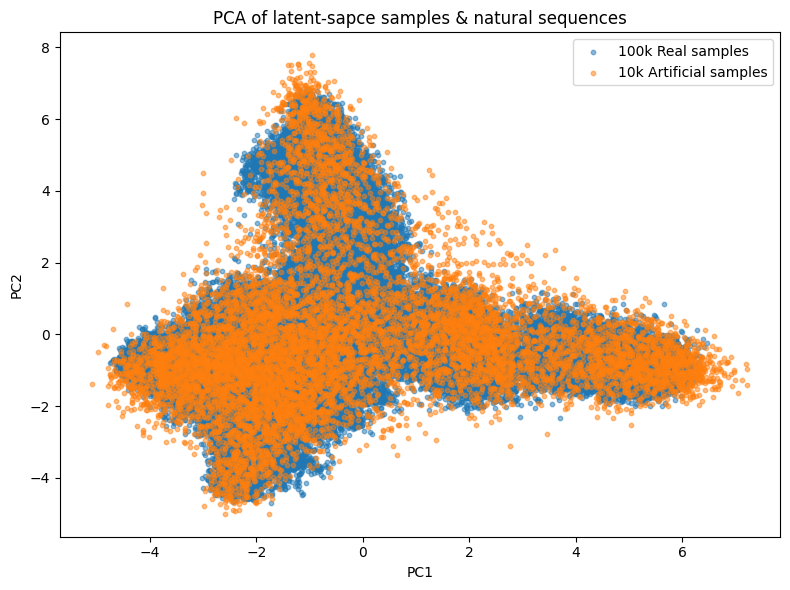

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



# --- Parameters ---
unlabeled_fasta   = 'PF00069_noinserts_gaps_noduplicates.fasta'
artificial_fasta  = 'artificial_sequences/latent_samples_10000.fasta'
n_real = 100000
max_length = 263

# 1) Load & sample real
all_real = read_fasta(unlabeled_fasta)
sel_idxs  = np.random.choice(len(all_real), size=n_real, replace=False)
real_seqs = [all_real[i] for i in sel_idxs]

# 2) Load artificial
art_seqs = read_fasta(artificial_fasta)

# 3) One-hot encode
X_real_oh = encode_sequences_one_hot_with_gap(real_seqs, max_length)
X_art_oh  = encode_sequences_one_hot_with_gap(art_seqs,  max_length)

# 4) Flatten and embed
N_real, L, A = X_real_oh.shape
N_art = X_art_oh.shape[0]
X_real_flat = X_real_oh.reshape(N_real, L*A)
X_art_flat  = X_art_oh.reshape(N_art, L*A)

# 5) Combine and perform PCA
X_combined = np.vstack([X_real_flat, X_art_flat])
pca = PCA(n_components=2)
X2 = pca.fit_transform(X_combined)

# 6) Plot PC1 vs PC2
plt.figure(figsize=(8,6))
plt.scatter(X2[:N_real, 0], X2[:N_real, 1], s=10, alpha=0.5, label='100k Real samples')
plt.scatter(X2[N_real:, 0], X2[N_real:, 1], s=10, alpha=0.5, label='10k Artificial samples')
plt.legend()
plt.title('PCA of latent-sapce samples & natural sequences')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

C:\Users\sajdv\AppData\Local\Temp\ipykernel_18876\3155521138.py:79: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


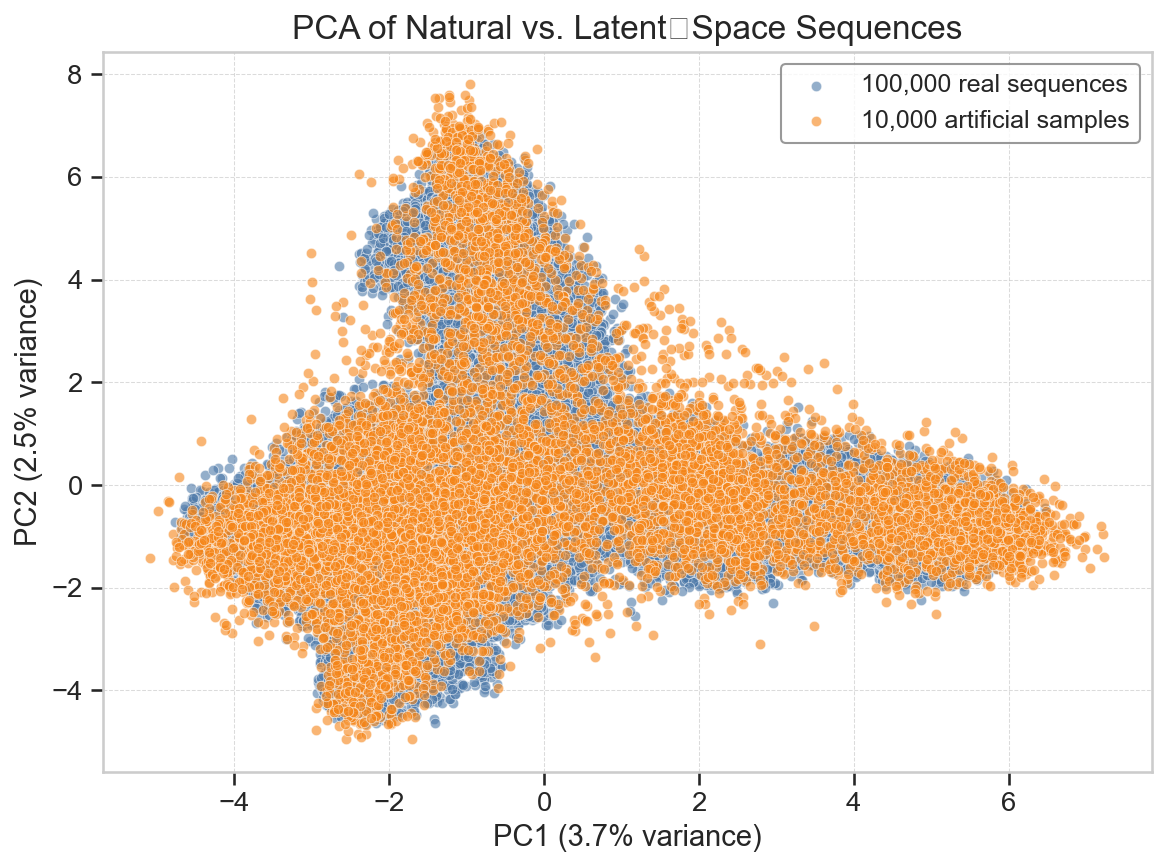

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Optional: tweak global matplotlib settings for larger fonts & cleaner look
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'figure.dpi': 150,
})

# --- Parameters ---
unlabeled_fasta   = 'PF00069_noinserts_gaps_noduplicates.fasta'
artificial_fasta  = 'artificial_sequences/latent_samples_10000.fasta'
n_real            = 100000
max_length        = 263

# 1) Load & sample real
all_real = read_fasta(unlabeled_fasta)
sel_idxs  = np.random.choice(len(all_real), size=n_real, replace=False)
real_seqs = [all_real[i] for i in sel_idxs]

# 2) Load artificial
art_seqs = read_fasta(artificial_fasta)

# 3) One-hot encode
X_real_oh = encode_sequences_one_hot_with_gap(real_seqs, max_length)
X_art_oh  = encode_sequences_one_hot_with_gap(art_seqs,  max_length)

# 4) Flatten and embed
N_real, L, A = X_real_oh.shape
N_art        = X_art_oh.shape[0]
X_real_flat  = X_real_oh.reshape(N_real, L*A)
X_art_flat   = X_art_oh.reshape(N_art, L*A)

# 5) Combine and perform PCA
X_combined = np.vstack([X_real_flat, X_art_flat])
pca        = PCA(n_components=2)
X2         = pca.fit_transform(X_combined)

# Grab explained variance for axis labels
var1, var2 = pca.explained_variance_ratio_ * 100

# 6) Plot PC1 vs PC2
fig, ax = plt.subplots(figsize=(8,6))

# Real samples
ax.scatter(
    X2[:N_real, 0], X2[:N_real, 1],
    s=25,
    c='#4C78A8',              # poster‐friendly blue
    edgecolors='white',
    linewidths=0.4,
    alpha=0.6,
    label=f'{n_real:,} real sequences'
)

# Artificial samples
ax.scatter(
    X2[N_real:, 0], X2[N_real:, 1],
    s=25,
    c='#F58518',              # contrasting orange
    edgecolors='white',
    linewidths=0.4,
    alpha=0.6,
    label=f'{N_art:,} artificial samples'
)

# Add grid, legend, and labels
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_xlabel(f'PC1 ({var1:.1f}% variance)')
ax.set_ylabel(f'PC2 ({var2:.1f}% variance)')
ax.set_title('PCA of Natural vs. Latent‐Space Sequences')
ax.legend(frameon=True, facecolor='white', edgecolor='gray')

plt.tight_layout()
plt.show()


## Generating 10k from 1k (10 each)

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Paths & params
unlabeled_fasta = 'PF00069_noinserts_gaps_noduplicates.fasta'
output_dir      = 'artificial_sequences'
os.makedirs(output_dir, exist_ok=True)

n_natural      = 1000
n_recon        = 10
max_length     = 263
amino_acids    = '-ACDEFGHIKLMNPQRSTVWY'
n_pca_sample   = 10000

# 1) Sample 1k natural for reconstruction
all_seqs = read_fasta(unlabeled_fasta)
idxs     = np.random.choice(len(all_seqs), size=n_natural, replace=False)
nat_seqs = [all_seqs[i] for i in idxs]

# 2) One-hot encode & flatten natural
X_nat = encode_sequences_one_hot_with_gap(nat_seqs, max_length)
N, L, A = X_nat.shape
X_nat_flat = X_nat.reshape(N, L*A)

# 3) Reconstruct each 10× via VAE
recon_seqs = []
for run in range(n_recon):
    recon_flat = vae(X_nat_flat).numpy()
    recon_oh   = recon_flat.reshape(N, L, A)
    for row in recon_oh:
        aa_idx = np.argmax(row, axis=1)
        recon_seqs.append(''.join(amino_acids[j] for j in aa_idx))
    print(f"Reconstruction round {run+1}/{n_recon}")

# 4) Save reconstructed FASTA
out_fa = os.path.join(output_dir, f'reconstructed_{N*n_recon}.fasta')
with open(out_fa, 'w') as f:
    for i, seq in enumerate(recon_seqs):
        f.write(f">recon_{i}\n{seq}\n")
print(f"Saved {len(recon_seqs)} sequences to {out_fa}")

Reconstruction round 1/10
Reconstruction round 2/10
Reconstruction round 3/10
Reconstruction round 4/10
Reconstruction round 5/10
Reconstruction round 6/10
Reconstruction round 7/10
Reconstruction round 8/10
Reconstruction round 9/10
Reconstruction round 10/10
Saved 9990 sequences to artificial_sequences\reconstructed_9990.fasta


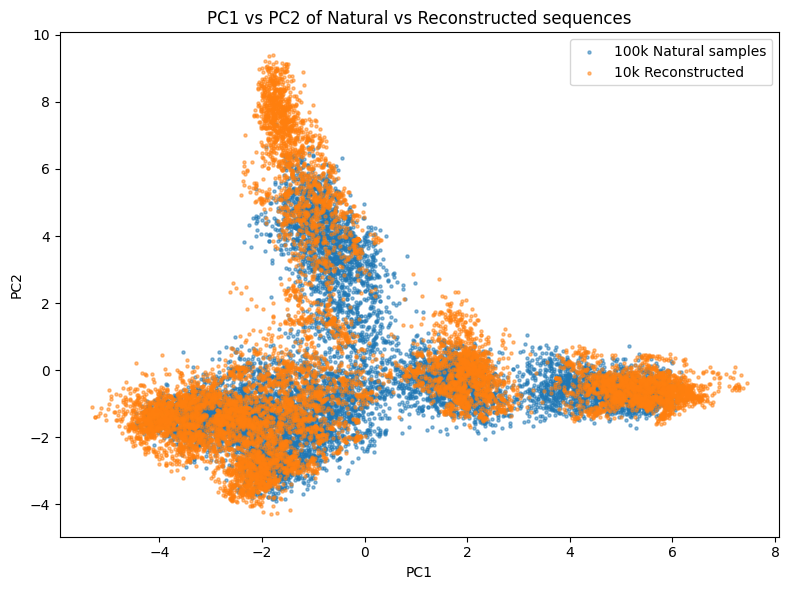

In [9]:
# 5) Sample 10k natural for PCA
idxs2 = np.random.choice(len(all_seqs), size=n_pca_sample, replace=False)
pca_nat_seqs = [all_seqs[i] for i in idxs2]

# 4b) One-hot & flatten for PCA
X_pca_nat_ = encode_sequences_one_hot_with_gap(pca_nat_seqs, max_length)
AA, L, A = X_pca_nat_.shape
X_pca_nat = X_pca_nat_.reshape(AA, L*A)


X_pca_rec_ = encode_sequences_one_hot_with_gap(recon_seqs, max_length)
AA, L, A = X_pca_rec_.shape
X_pca_rec = X_pca_rec_.reshape(AA, L*A)

# 7) Run PCA on the flattened one-hot space
X_combined = np.vstack([X_pca_nat, X_pca_rec])
pca = PCA(n_components=2)
X2  = pca.fit_transform(X_combined)

# 8) Plot PC1 vs PC2
plt.figure(figsize=(8,6))
plt.scatter(X2[:n_pca_sample, 0], X2[:n_pca_sample, 1],
            s=5, alpha=0.5, label='100k Natural samples')
plt.scatter(X2[n_pca_sample:, 0], X2[n_pca_sample:, 1],
            s=5, alpha=0.5, label='10k Reconstructed')
plt.legend()
plt.title('PC1 vs PC2 of Natural vs Reconstructed sequences')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()


# Average Pairwise Intra-Hamming Distance

In [5]:
import numpy as np
from itertools import combinations
from scipy.spatial.distance import hamming
from Bio import SeqIO

# --- File paths ---
artificial_fasta = 'artificial_sequences/latent_samples_10000.fasta'
natural_fasta = 'PF00069_noinserts_gaps_noduplicates.fasta'

# --- Parameters ---
n_natural = 1000  # number of natural sequences to compare against
max_length = 263  # consistent with your encoding

# --- Helper: Read FASTA ---
def read_fasta_sequences(filepath, max_seqs=None):
    sequences = []
    for record in SeqIO.parse(filepath, "fasta"):
        seq = str(record.seq)
        if len(seq) == max_length:  # only keep sequences of correct length
            sequences.append(seq)
        if max_seqs and len(sequences) >= max_seqs:
            break
    return sequences

# --- Load sequences ---
gen_sequences = read_fasta_sequences(artificial_fasta)
nat_sequences = read_fasta_sequences(natural_fasta, max_seqs=n_natural)

# --- Intra-Hamming Distance ---
def average_pairwise_hamming(sequences):
    distances = []
    for s1, s2 in combinations(sequences, 2):
        dist = hamming(list(s1), list(s2)) * len(s1)
        distances.append(dist)
    return np.mean(distances)

# --- Minimum Hamming Distance to Natural Set ---
def average_min_distance_to_natural(generated_seqs, natural_seqs):
    min_distances = []
    for gen_seq in generated_seqs:
        dists = [hamming(list(gen_seq), list(nat_seq)) * len(gen_seq) for nat_seq in natural_seqs]
        min_distances.append(min(dists))
    return np.mean(min_distances)


In [6]:
# --- Compute distances ---
avg_intra_dist = average_pairwise_hamming(gen_sequences[:1000])  # subset to avoid O(n^2) for 10k
avg_min_dist_to_nat = average_min_distance_to_natural(gen_sequences, nat_sequences)

(avg_intra_dist, avg_min_dist_to_nat)

(183.43534934934934, 128.8506)

Average Pairwise Intra-Hamming Distance is 183.4 (70%) => 1,000 generated sequences differ from each other by about 183 amino acids (on average).

Average Min Hamming Distance to Naturals is 129 (49%) => Each generated sequence is on average ~129 amino acids different from its closest real sequence.

In [8]:
# Parameters
n_natural = 1000
max_length = 263

# Load and filter sequences
gen_sequences = [seq for seq in read_fasta(artificial_fasta) if len(seq) == max_length]
nat_sequences = [seq for seq in read_fasta(natural_fasta) if len(seq) == max_length][:n_natural]

# Distance distributions
def get_pairwise_distances(sequences):
    return [hamming(list(s1), list(s2)) * len(s1) for s1, s2 in combinations(sequences, 2)]

def get_min_distances(source, target):
    return [min([hamming(list(s), list(t)) * len(s) for t in target]) for s in source]

# Compute distributions
gen_intra_dists = get_pairwise_distances(gen_sequences[:500])  # subset for speed
gen_to_nat_min_dists = get_min_distances(gen_sequences, nat_sequences)
nat_intra_dists = get_pairwise_distances(nat_sequences[:500])
nat_to_nat_min_dists = get_min_distances(nat_sequences, nat_sequences)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame for seaborn
df = pd.DataFrame({
    'Generated Intra': gen_intra_dists,
    'Generated → Natural (min)': gen_to_nat_min_dists,
    'Natural Intra': nat_intra_dists,
    'Natural → Natural (min)': nat_to_nat_min_dists
})

# Melt for long-form plotting
df_melted = df.melt(var_name='Metric', value_name='Hamming Distance')

# Local replacements for ace_tools
print(df_melted.head())
print(df_melted.describe())

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_melted, x='Metric', y='Hamming Distance', inner='quartile')
plt.title("Hamming Distance Distributions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ValueError: All arrays must be of the same length

In [13]:
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import sklearn.utils

In [11]:
# --- Step 2: Load model ---
original_dim = 5523
latent_dim = 32
vae = VAE(original_dim=original_dim, latent_dim=latent_dim)
vae(np.zeros((1, original_dim), dtype=np.float32))  # build
vae.load_weights('models/200000seq_best_vae_model.h5')

# --- Step 3: Read FASTA ---
def read_fasta(path):
    seqs = []
    with open(path, 'r') as f:
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    seqs.append(seq)
                    seq = ""
            else:
                seq += line
        if seq:
            seqs.append(seq)
    return seqs

# --- Step 4: Generate synthetic sequences ---
N = 20000
amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
z = np.random.normal(size=(N, latent_dim))
decoded = vae.decode(z).numpy()
seq_len = decoded.shape[1] // len(amino_acids)
decoded = decoded.reshape(N, seq_len, len(amino_acids))
artificial_seqs = ["".join(amino_acids[np.argmax(p)] for p in decoded[i]) for i in range(N)]

# --- Step 5: Get natural sequences ---
all_real = read_fasta("PF00069_noinserts_gaps_noduplicates.fasta")
natural_seqs = random.sample([s for s in all_real if len(s) == seq_len], N)

# --- Step 6: One-hot encoding ---
def encode_onehot(seqs, aa_map, maxlen):
    data = np.zeros((len(seqs), maxlen, len(aa_map)), dtype=np.float32)
    for i, seq in enumerate(seqs):
        for j, aa in enumerate(seq[:maxlen]):
            if aa in aa_map:
                data[i, j, aa_map[aa]] = 1.0
    return data.reshape(len(seqs), -1)

aa_map = {aa: i for i, aa in enumerate(amino_acids)}
X_artificial = encode_onehot(artificial_seqs, aa_map, seq_len)
X_natural = encode_onehot(natural_seqs, aa_map, seq_len)



In [14]:
# --- Step 7: Build dataset ---
X = np.concatenate([X_artificial, X_natural], axis=0)
y = np.array([1]*N + [0]*N)
X, y = shuffle = sklearn.utils.shuffle(X, y, random_state=42)

In [15]:
# --- Step 8: Train-test split & classifier ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]


Accuracy: 0.964
ROC AUC: 0.9933898712818026
Confusion matrix:
 [[3894  109]
 [ 179 3818]]


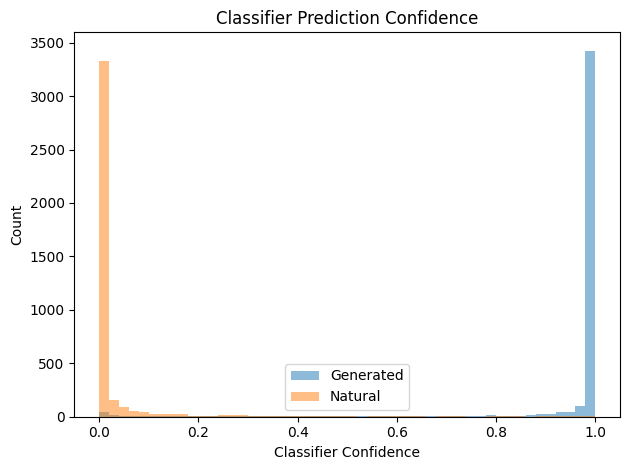

In [17]:
# --- Step 9: Evaluation ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_score))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: plot histogram of prediction probabilities
plt.hist(y_score[y_test==1], bins=50, alpha=0.5, label='Generated')
plt.hist(y_score[y_test==0], bins=50, alpha=0.5, label='Natural')
plt.xlabel("Classifier Confidence")
plt.ylabel("Count")
plt.legend()
plt.title("Classifier Prediction Confidence")
plt.tight_layout()
plt.show()